# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

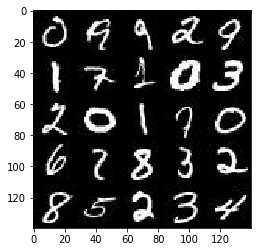

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

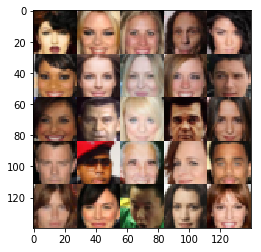

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha= 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha= 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 6x6x256 
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 12x12x128
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x?
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()    

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    tf.reset_default_graph()
    #image_channel = 3 if (data_image_mode = 'RGB') else 1
    input_real, input_z, tf_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, tf_learning_rate:learning_rate})

                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 1000 == 0:
                    show_generator_output(sess, 12, input_z, data_shape[3],data_image_mode)

        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator')
        plt.plot(losses.T[1], label='Generator')
        plt.title("Training Losses")
        plt.legend()
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 0.1676... Generator Loss: 3.6319
Epoch 1/2... Discriminator Loss: 0.0596... Generator Loss: 4.1986
Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 1.9214
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 2.9034
Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 3.2047
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.0993
Epoch 1/2... Discriminator Loss: 0.5977... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.5319


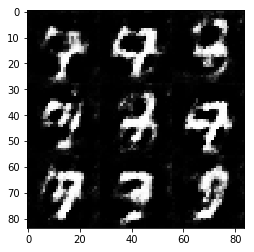

Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 1.2853
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.3441
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.8316
Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 1.5348
Epoch 1/2... Discriminator Loss: 0.5881... Generator Loss: 1.2372
Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 1.6809
Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 1.0856
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.1416


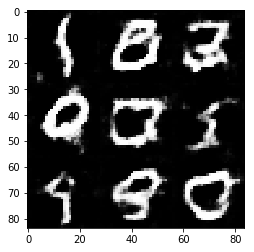

Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 0.5088... Generator Loss: 1.6053
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 0.7227... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 1.9665


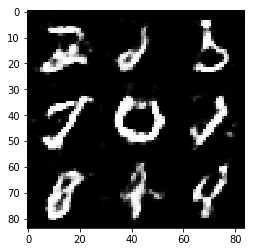

Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.2977... Generator Loss: 1.7606
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 1.6002


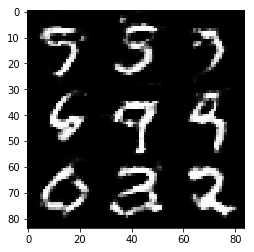

Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 2.0925
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 1.0357
Epoch 1/2... Discriminator Loss: 0.2970... Generator Loss: 2.0899
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 2.1335
Epoch 1/2... Discriminator Loss: 0.5087... Generator Loss: 1.1384
Epoch 1/2... Discriminator Loss: 0.1464... Generator Loss: 3.0637


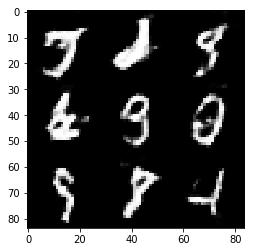

Epoch 1/2... Discriminator Loss: 0.2803... Generator Loss: 2.1868
Epoch 1/2... Discriminator Loss: 0.3036... Generator Loss: 1.6831
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 0.2840... Generator Loss: 1.9395
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 0.1642... Generator Loss: 3.4068
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 0.4770... Generator Loss: 1.3796
Epoch 1/2... Discriminator Loss: 0.2049... Generator Loss: 2.4745


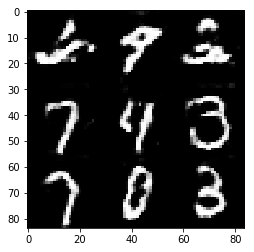

Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 1.7704
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 0.2004... Generator Loss: 2.2368
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 1.5612
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 0.4537... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 0.1981... Generator Loss: 2.0667
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 1.3045
Epoch 2/2... Discriminator Loss: 0.2603... Generator Loss: 1.8471


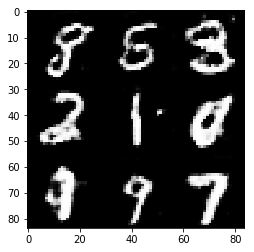

Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.2735
Epoch 2/2... Discriminator Loss: 0.4480... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 0.6693
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 2.2759
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 0.2827... Generator Loss: 1.7728


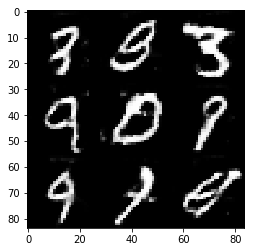

Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.2747... Generator Loss: 1.7670
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.2530... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 0.3382... Generator Loss: 1.4514
Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 1.4161
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 0.2274... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: 1.6422... Generator Loss: 0.3509
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 1.2206


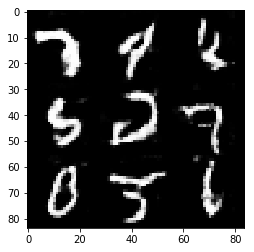

Epoch 2/2... Discriminator Loss: 0.2998... Generator Loss: 1.6775
Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 1.8908
Epoch 2/2... Discriminator Loss: 0.1870... Generator Loss: 2.5186
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 0.2435... Generator Loss: 2.0793
Epoch 2/2... Discriminator Loss: 0.6534... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 0.3342... Generator Loss: 1.8129
Epoch 2/2... Discriminator Loss: 4.9077... Generator Loss: 0.0231


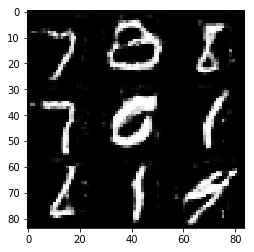

Epoch 2/2... Discriminator Loss: 0.0720... Generator Loss: 3.2664
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 0.3111... Generator Loss: 1.4544
Epoch 2/2... Discriminator Loss: 1.8512... Generator Loss: 0.2277
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 1.3687
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 1.4910
Epoch 2/2... Discriminator Loss: 0.1564... Generator Loss: 2.6438
Epoch 2/2... Discriminator Loss: 0.1522... Generator Loss: 3.3412


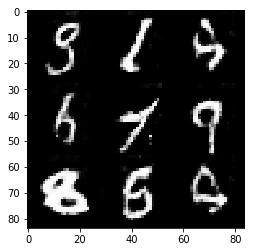

Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.2309... Generator Loss: 1.9787
Epoch 2/2... Discriminator Loss: 0.1916... Generator Loss: 2.7297
Epoch 2/2... Discriminator Loss: 0.3193... Generator Loss: 2.2001
Epoch 2/2... Discriminator Loss: 0.1436... Generator Loss: 2.3339
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 0.2574... Generator Loss: 2.5532


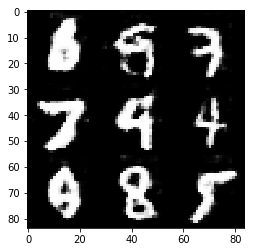

IndexError: list index out of range

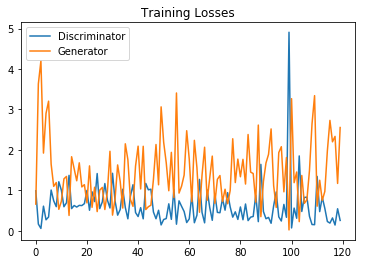

In [19]:
batch_size = 10
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.1408... Generator Loss: 4.0832
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 3.1259
Epoch 1/2... Discriminator Loss: 0.0462... Generator Loss: 3.7149
Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 0.9918
Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 2.8880
Epoch 1/2... Discriminator Loss: 0.0304... Generator Loss: 4.4549
Epoch 1/2... Discriminator Loss: 0.0307... Generator Loss: 9.5289
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 6.8426
Epoch 1/2... Discriminator Loss: 0.1677... Generator Loss: 3.0590
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.2489


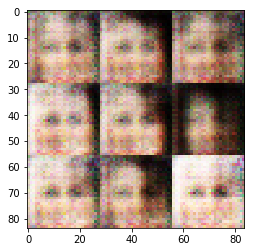

Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.4587... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 1.4750
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.8952


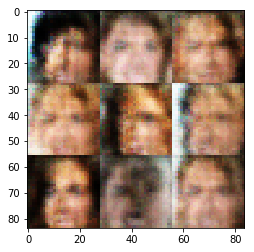

Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 0.7123... Generator Loss: 1.0993


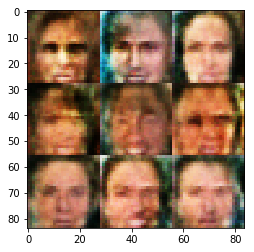

Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.4562


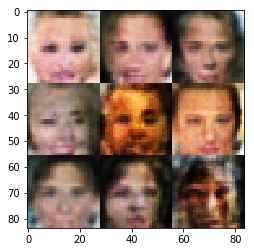

Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.6209
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.4246
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.7779


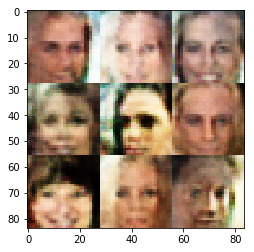

Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.1135
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.1461
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.5685
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.0082


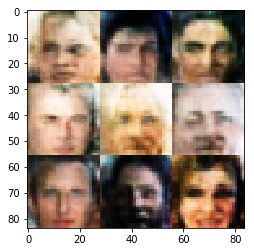

Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.9930
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.5663
Epoch 1/2... Discriminator Loss: 1.1184... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 1.0451


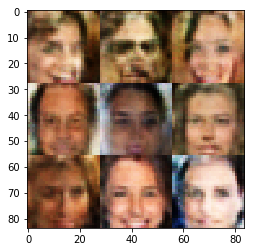

Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.5960... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.1555
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 0.8318


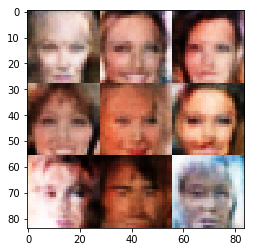

Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.9699
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.7183


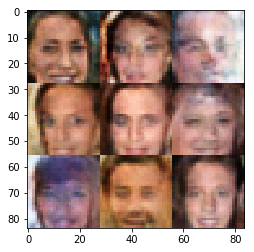

Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.9246


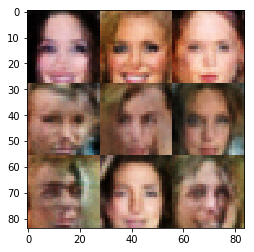

Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.6737
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 0.8181


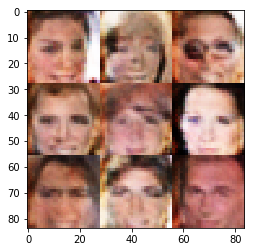

Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 0.4767... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 0.7259


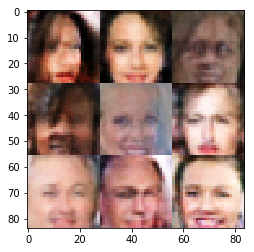

Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.8829
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.5301


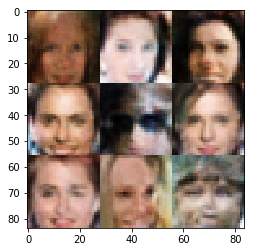

Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 0.9280
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.0621
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 0.6042


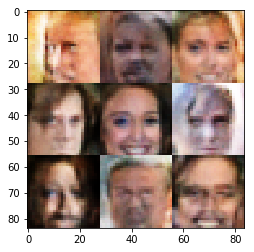

Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.5829


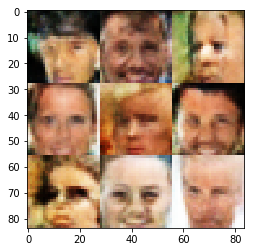

Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.5470
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 0.6792... Generator Loss: 1.0071
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 0.6894


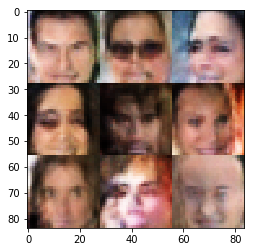

Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.7534... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.0587
Epoch 1/2... Discriminator Loss: 0.9192... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 1.4540
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 0.7514


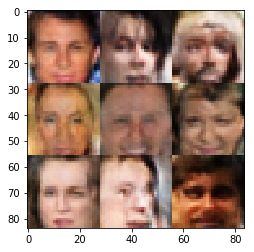

Epoch 1/2... Discriminator Loss: 0.8498... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.2366
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.3489
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 0.9504


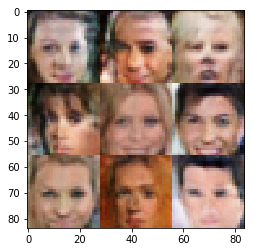

Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.1923
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.7785


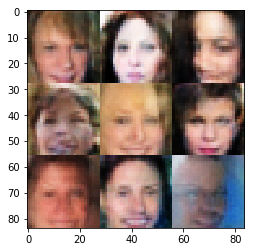

Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.1305
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.6142


In [ ]:
batch_size = 10
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.